In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

In [17]:
end = pd.read_csv('./data/완성본.csv', encoding='cp949')

end['1인당 자동차 등록대수'] = end['자동차 등록대수']/end['인구수']
end.drop('자동차 등록대수', axis=1, inplace = True)

dc = ['행정구', '행정동', '인구수','10대 비율', '20대 비율', '3040 비율', '65세 이상 비율', '사업체수', 
               '종사자수', '집 개수', '소득', '버스정류장 개수', '지하철역 개수','도로 평균 속도', '1인당 자동차 등록대수', ' 버스 승차량']

end = end[dc]

end.columns = ['행정구', '행정동', '인구수','10대 비율', '20대 비율', '3040 비율', '65세 이상 비율', '사업체수', 
               '종사자수', '집 개수', '소득', '버스정류장 개수', '지하철역 개수','도로 평균 속도', '1인당 자동차 등록대수', '버스 승차량']

end.head()

,행정구,행정동,인구수,10대 비율,20대 비율,3040 비율,65세 이상 비율,사업체수,종사자수,집 개수,소득,버스정류장 개수,지하철역 개수,도로 평균 속도,1인당 자동차 등록대수,버스 승차량
0,송파구,가락1동,27670,0.096314,0.095699,0.354355,0.142212,3791,12367,9716,4973588,14,3,16.42,0.412215,2536468
1,송파구,가락2동,31450,0.103529,0.130175,0.310715,0.149571,3155,11544,10424,3910198,21,2,15.61,0.342067,2364616
2,송파구,가락본동,25617,0.063552,0.140571,0.318070,0.164930,5069,28151,8410,3521561,25,1,16.24,0.491314,3266207
3,구로구,가리봉동,12478,0.025325,0.146818,0.285062,0.178875,1189,4248,2551,2336331,9,0,15.08,0.218785,2449595
4,금천구,가산동,27166,0.025068,0.268571,0.376058,0.110248,25043,182376,6200,2567594,105,3,18.46,0.736582,11305765


In [18]:
bus_loc = pd.read_csv('./data/서울시버스정류소위치정보(20240110).csv')
bus_loc['ARS_ID'] = bus_loc['ARS_ID'].astype('str')
bus_loc.head()

,NODE_ID,ARS_ID,정류소명,X좌표,Y좌표,정류소타입
0,100000001,1001,종로2가사거리,126.987752,37.569806,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996521,37.579433,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582580,중앙차로
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로


In [19]:
route = pd.read_excel('./data/서울시 시내버스 노선수.xlsx')
route['ID'] = route['ID'].str.replace('-','')
route.loc[route[route['ID'].str[0] == '0'].index, 'ID'] = route['ID'].str[1:]


In [20]:
merge_df = pd.merge(route, bus_loc, left_on='ID', right_on='ARS_ID', how='left')
merge_df = merge_df[['자치구', 'ID', '정류소명', '노선수', 'X좌표', 'Y좌표']]
route_count = merge_df[~merge_df.isnull().any(axis=1)]

In [21]:
boundary = gpd.read_file('./data/행정동경계', encoding='cp949')
boundary['ADM_CD'] = boundary['ADM_CD'].astype('str')
seoul_boundary = boundary[boundary['ADM_CD'].str[0] == '1']
seoul_boundary

,BASE_DATE,ADM_CD,ADM_NM,geometry
0,20220630,11010530,사직동,"POLYGON ((197702.069 553187.311, 197703.431 55..."
1,20220630,11010540,삼청동,"POLYGON ((198170.457 553770.678, 198172.189 55..."
2,20220630,11010550,부암동,"POLYGON ((196621.023 556395.880, 196628.323 55..."
3,20220630,11010560,평창동,"POLYGON ((197800.719 559064.245, 197782.581 55..."
4,20220630,11010570,무악동,"POLYGON ((196444.745 553384.564, 196471.618 55..."
...,...,...,...,...
421,20220630,11250730,천호2동,"POLYGON ((210279.972 550065.332, 210287.877 55..."
422,20220630,11250740,길동,"POLYGON ((213117.764 549557.375, 213117.393 54..."
423,20220630,11250750,강일동,"POLYGON ((215607.323 553294.531, 215601.339 55..."
424,20220630,11250760,상일1동,"POLYGON ((215364.723 549613.445, 215368.026 54..."


In [22]:
from shapely.geometry import Point, Polygon, LineString

route_count['geometry'] = route_count.apply(lambda row : Point([row['X좌표'], row['Y좌표']]), axis=1)
route_count

route_count = gpd.GeoDataFrame(route_count)

route_count.set_crs(epsg=4326, inplace=True)
route_count.to_crs(epsg=5186, inplace = True)

route_dong = gpd.sjoin(route_count, seoul_boundary)

route_dong

C:\Users\KJY\AppData\Local\Temp\ipykernel_33848\2743701009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_count['geometry'] = route_count.apply(lambda row : Point([row['X좌표'], row['Y좌표']]), axis=1)


,자치구,ID,정류소명,노선수,X좌표,Y좌표,geometry,index_right,BASE_DATE,ADM_CD,ADM_NM
0,종로구,1001,종로2가사거리,10,126.987752,37.569806,POINT (198918.001 552251.750),7,20220630,11010610,종로1·2·3·4가동
3,종로구,1004,종로2가.삼일교,7,126.987613,37.568579,POINT (198905.685 552115.650),7,20220630,11010610,종로1·2·3·4가동
9,종로구,1010,광화문,17,126.977880,37.570240,POINT (198045.889 552300.092),7,20220630,11010610,종로1·2·3·4가동
10,종로구,1011,종로1가,19,126.981066,37.570148,POINT (198327.329 552289.885),7,20220630,11010610,종로1·2·3·4가동
11,종로구,1012,종로1가,18,126.981628,37.570271,POINT (198376.998 552303.500),7,20220630,11010610,종로1·2·3·4가동
...,...,...,...,...,...,...,...,...,...,...,...
6611,강동구,25643,성덕중고등학교,6,127.142691,37.550646,POINT (212609.000 550134.750),413,20220630,11250610,천호1동
6613,강동구,25650,강동농협,4,127.135338,37.548070,POINT (211959.641 549847.952),413,20220630,11250610,천호1동
6614,강동구,25651,강동농협,4,127.135904,37.548400,POINT (212009.658 549884.612),413,20220630,11250610,천호1동
6616,강동구,25654,천호초교입구사거리,5,127.134213,37.546491,POINT (211860.476 549672.541),413,20220630,11250610,천호1동


In [23]:
cond1 = (route_dong['ADM_NM']=='신사동') & (route_dong['자치구']=='관악구')
cond2 = (route_dong['ADM_NM']=='신사동') & (route_dong['자치구']=='강남구')
cond3 = (route_dong['ADM_NM']=='상일1동') | (route_dong['ADM_NM']=='상일2동')
cond4 = (route_dong['ADM_NM']=='일원2동')

route_dong.loc[route_dong[cond1].index, 'ADM_NM'] = '신사동1'
route_dong.loc[route_dong[cond2].index, 'ADM_NM'] = '신사동2'
route_dong.loc[route_dong[cond3].index, 'ADM_NM'] = '상일동'
route_dong.loc[route_dong[cond4].index, 'ADM_NM'] = '개포3동'


In [24]:
route_dong[(route_dong['ADM_NM']=='신사동2') & (route_dong['자치구']=='강남구')].groupby('ADM_NM').sum()

,노선수,X좌표,Y좌표,index_right
ADM_NM,,,,
신사동2,67,1270.231107,375.224597,3580


In [25]:
pd.set_option('display.max_rows', 10)
route_sum = route_dong.groupby('ADM_NM').sum()
route_sum.reset_index(inplace = True)
route_sum = route_sum[['ADM_NM', '노선수']]
route_sum.columns = ['행정동', '시내버스 노선수']

route_sum['행정동'] = route_sum['행정동'].str.replace('·', '.')

In [26]:
df20 = end.merge(route_sum, left_on='행정동', right_on='행정동', how='left')
df20[df20.isnull().any(axis=1)]

df20.loc[245, '시내버스 노선수'] = 71
df20.loc[246, '시내버스 노선수'] = 67

df20['시내버스 노선수'] = df20['시내버스 노선수'].fillna(0)
df20

df22 = df20.iloc[:, :-2]
df21 = df20.iloc[:, -2:]
df21 = df21[['시내버스 노선수', '버스 승차량']]

df20 = pd.concat([df22, df21], axis=1)

df20.to_csv('시내버스 노선수 추가.csv', encoding='cp949')

In [27]:
df20.head()

,행정구,행정동,인구수,10대 비율,20대 비율,3040 비율,65세 이상 비율,사업체수,종사자수,집 개수,소득,버스정류장 개수,지하철역 개수,도로 평균 속도,1인당 자동차 등록대수,시내버스 노선수,버스 승차량
0,송파구,가락1동,27670,0.096314,0.095699,0.354355,0.142212,3791,12367,9716,4973588,14,3,16.42,0.412215,131.0,2536468
1,송파구,가락2동,31450,0.103529,0.130175,0.310715,0.149571,3155,11544,10424,3910198,21,2,15.61,0.342067,60.0,2364616
2,송파구,가락본동,25617,0.063552,0.140571,0.318070,0.164930,5069,28151,8410,3521561,25,1,16.24,0.491314,105.0,3266207
3,구로구,가리봉동,12478,0.025325,0.146818,0.285062,0.178875,1189,4248,2551,2336331,9,0,15.08,0.218785,63.0,2449595
4,금천구,가산동,27166,0.025068,0.268571,0.376058,0.110248,25043,182376,6200,2567594,105,3,18.46,0.736582,199.0,11305765


In [28]:
df20.to_excel('전체데이터.xlsx', encoding='cp949')

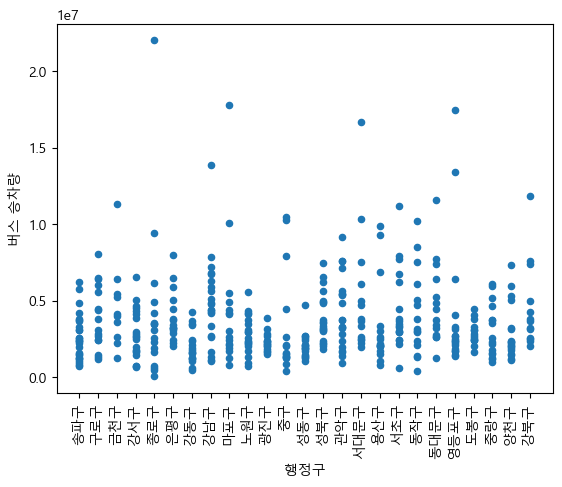

In [29]:
df20.plot(kind='scatter', x='행정구', y='버스 승차량')
plt.xticks(rotation=90)
plt.show()

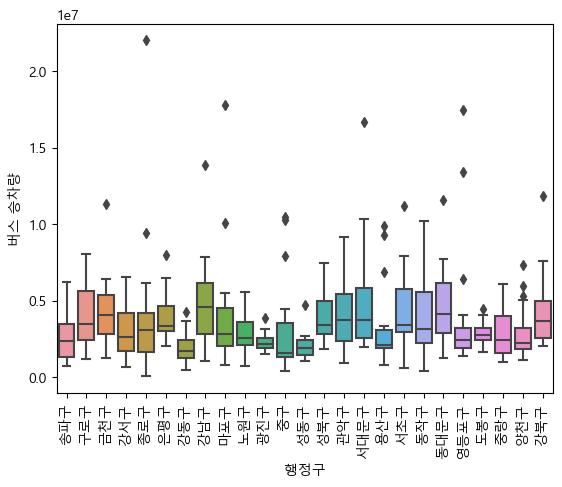

In [30]:
sns.boxplot(data=df20, x='행정구', y='버스 승차량')
plt.xticks(rotation=90)
plt.show()

In [31]:
bus_top10 = df20.sort_values('버스 승차량', ascending=False)[:10]

In [32]:
## 버스 탑승량 시각화 지도 시각화

geo = gpd.read_file('./data/HangJeongDong_ver20230701.geojson')


In [33]:
geo_seoul = geo[geo['sidonm'] == '서울특별시']
geo_seoul['행정동'] = geo_seoul['temp'].str.split(' ').str[1]
geo_seoul.sort_values('행정동', inplace = True)
geo_seoul.reset_index(inplace=True, drop=True)

geo_seoul.loc[geo_seoul[(geo_seoul['행정동'] == '상일제1동') | (geo_seoul['행정동'] == '상일제2동')].index, '행정동']  = '상일동'

from shapely.geometry import MultiPolygon
from shapely.geometry import MultiPolygon, Polygon

sang = geo_seoul[geo_seoul['행정동'] == '상일동'][['geometry']]
sang.reset_index(drop= True, inplace = True)
merge_poly = sang.iloc[0, 0].union(sang.iloc[1,0])

geo_seoul.drop(187, axis=0, inplace = True)
geo_seoul.loc[186, 'geometry'] = merge_poly
geo_seoul.reset_index(inplace = True, drop=True)

c:\Users\KJY\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\KJY\AppData\Local\Temp\ipykernel_33848\745108538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_seoul.sort_values('행정동', inplace = True)
C:\Users\KJY\AppData\Local\Temp\ipykernel_33848\745108538.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [34]:
geo_seoul = geo_seoul[['sggnm', 'geometry', '행정동']]

In [41]:
pd.set_option('display.max_rows', 10)
df30 = pd.concat([df20, geo_seoul], axis=1)
df30
df30 = gpd.GeoDataFrame(df30)

In [115]:
df30.columns

Index(['행정구', '행정동', '인구수', '10대 비율', '20대 비율', '3040 비율', '65세 이상 비율', '사업체수',
       '종사자수', '집 개수', '소득', '버스정류장 개수', '지하철역 개수', '도로 평균 속도', '1인당 자동차 등록대수',
       '시내버스 노선수', '버스 승차량', 'sggnm', 'geometry', '행정동'],
      dtype='object')

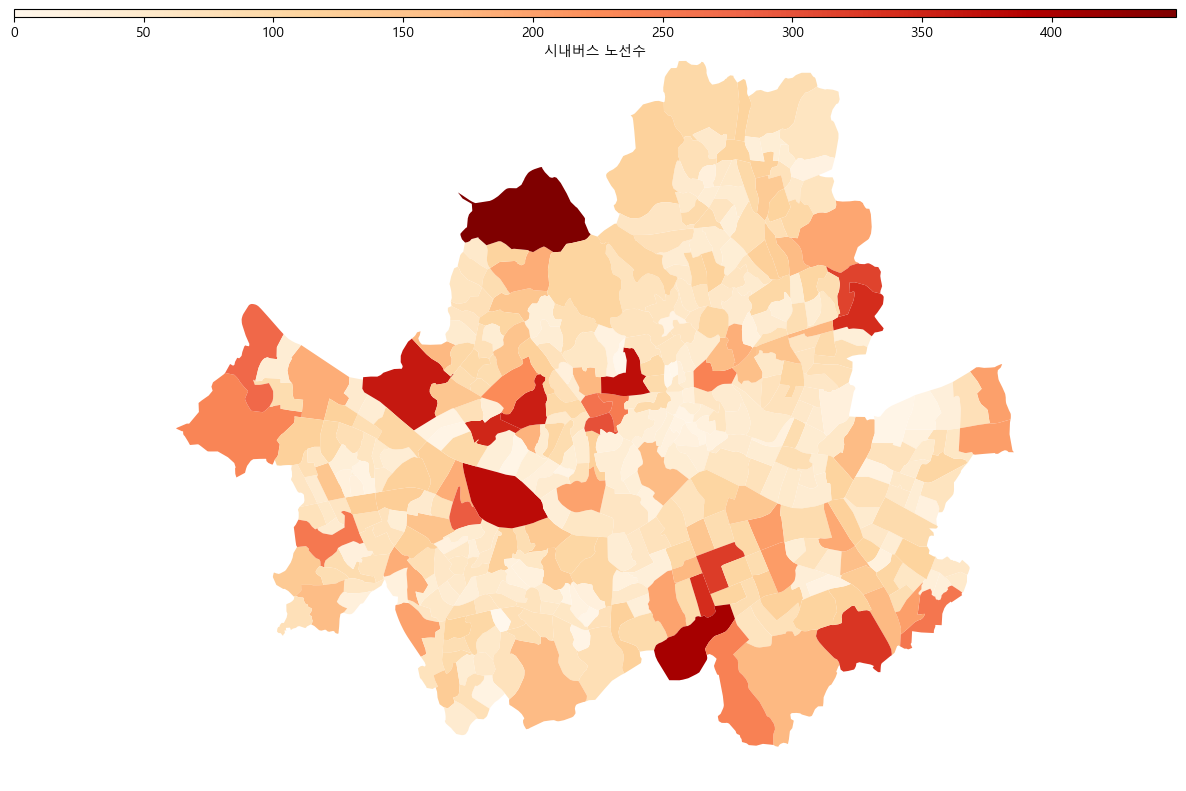

In [126]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(15, 15))

df30.plot(ax=ax, column='시내버스 노선수', cmap='OrRd', legend=False, alpha=1)


# 컬러바 위치 설정
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="1%", pad=0.1)

# 컬러바 생성 및 설정
cbar = plt.colorbar(ax.collections[0], cax=cax, orientation='horizontal')
cbar.set_label('시내버스 노선수')

ax.set_axis_off()

plt.show()

In [79]:
df20.head()
dong = df20[['행정구', '행정동']]

In [48]:
df20.head()

,행정구,행정동,인구수,10대 비율,20대 비율,3040 비율,65세 이상 비율,사업체수,종사자수,집 개수,소득,버스정류장 개수,지하철역 개수,도로 평균 속도,1인당 자동차 등록대수,시내버스 노선수,버스 승차량
0,송파구,가락1동,27670,0.096314,0.095699,0.354355,0.142212,3791,12367,9716,4973588,14,3,16.42,0.412215,131.0,2536468
1,송파구,가락2동,31450,0.103529,0.130175,0.310715,0.149571,3155,11544,10424,3910198,21,2,15.61,0.342067,60.0,2364616
2,송파구,가락본동,25617,0.063552,0.140571,0.318070,0.164930,5069,28151,8410,3521561,25,1,16.24,0.491314,105.0,3266207
3,구로구,가리봉동,12478,0.025325,0.146818,0.285062,0.178875,1189,4248,2551,2336331,9,0,15.08,0.218785,63.0,2449595
4,금천구,가산동,27166,0.025068,0.268571,0.376058,0.110248,25043,182376,6200,2567594,105,3,18.46,0.736582,199.0,11305765


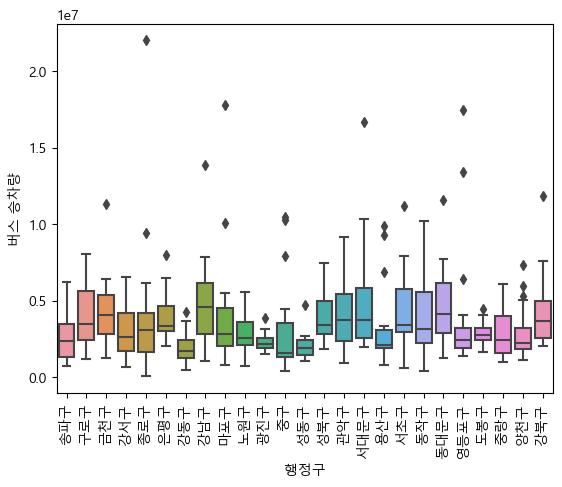

In [ ]:
sns.boxplot(data=df20, x='행정구', y='버스 승차량')
plt.xticks(rotation=90)
plt.show()

In [ ]:
############################3

In [50]:
X = df20.loc[:, '인구수':'시내버스 노선수']
y = df20.loc[:, '버스 승차량']

X
X.columns

Index(['인구수', '10대 비율', '20대 비율', '3040 비율', '65세 이상 비율', '사업체수', '종사자수',
       '집 개수', '소득', '버스정류장 개수', '지하철역 개수', '도로 평균 속도', '1인당 자동차 등록대수',
       '시내버스 노선수'],
      dtype='object')

In [51]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

X_standardized_df = pd.DataFrame(X_standardized, columns=X.columns)
X_standardized_df

,인구수,10대 비율,20대 비율,3040 비율,65세 이상 비율,사업체수,종사자수,집 개수,소득,버스정류장 개수,지하철역 개수,도로 평균 속도,1인당 자동차 등록대수,시내버스 노선수
0,0.542240,0.718111,-0.913039,1.333673,-1.024298,0.364621,-0.056896,0.857345,1.660721,-0.830630,1.775494,-0.269505,0.101059,0.636092
1,0.956298,0.958454,-0.345921,0.209427,-0.835352,0.131672,-0.095520,1.088935,0.546058,-0.364204,0.921891,-0.516883,-0.054508,-0.374920
2,0.317356,-0.373140,-0.174911,0.398897,-0.441005,0.832718,0.683850,0.430146,0.138683,-0.097675,0.068288,-0.324478,0.276475,0.265862
3,-1.121879,-1.646414,-0.072137,-0.451468,-0.082951,-0.588420,-0.437922,-1.486361,-1.103695,-1.163791,-0.785315,-0.678748,-0.327906,-0.332202
4,0.487032,-1.654957,1.930676,1.892799,-1.844987,8.148649,7.921659,-0.292756,-0.861281,5.232906,1.775494,0.353520,0.820399,1.604385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-1.302619,-0.404320,0.017876,0.907901,-0.876972,-0.766795,-0.515451,-1.188042,0.140402,-0.763998,-0.785315,-0.364181,-0.148289,-0.716671
421,-0.676931,-0.204268,-0.225672,0.469177,0.080682,-0.523224,-0.421168,-0.566542,-0.393690,-0.697365,-0.785315,0.353520,-0.274905,-0.901786
422,-0.717680,-0.644051,3.249009,-1.488578,-1.202605,-0.553258,-0.464109,-0.905423,-0.698619,-0.897262,0.068288,1.480464,-0.273770,-0.047410
423,0.281318,0.086428,1.808627,-1.328245,-0.373728,-0.414074,-0.381184,-0.095839,-0.332989,-0.564101,-0.785315,-0.406937,-0.255963,0.863925


In [54]:
# 인구수 열 제거

df100 = X_standardized_df.drop('인구수', axis=1)
no_pop = np.array(df100)
no_house = df100.drop('집 개수', axis =1)
no_subway = no_house.drop('지하철역 개수', axis=1)
no_worker = no_subway.drop('종사자수', axis=1)
no_grand = no_worker.drop('65세 이상 비율', axis=1)
no_car = no_grand.drop('1인당 자동차 등록대수', axis=1)
no_10 = no_car.drop('10대 비율', axis=1)
no_earn = no_10.drop('소득', axis=1)

no_earn

,20대 비율,3040 비율,사업체수,버스정류장 개수,도로 평균 속도,시내버스 노선수
0,-0.913039,1.333673,0.364621,-0.830630,-0.269505,0.636092
1,-0.345921,0.209427,0.131672,-0.364204,-0.516883,-0.374920
2,-0.174911,0.398897,0.832718,-0.097675,-0.324478,0.265862
3,-0.072137,-0.451468,-0.588420,-1.163791,-0.678748,-0.332202
4,1.930676,1.892799,8.148649,5.232906,0.353520,1.604385
...,...,...,...,...,...,...
420,0.017876,0.907901,-0.766795,-0.763998,-0.364181,-0.716671
421,-0.225672,0.469177,-0.523224,-0.697365,0.353520,-0.901786
422,3.249009,-1.488578,-0.553258,-0.897262,1.480464,-0.047410
423,1.808627,-1.328245,-0.414074,-0.564101,-0.406937,0.863925


In [56]:
model_standardized = sm.OLS(y, sm.add_constant(no_earn)).fit()

print(model_standardized.summary())


                            OLS Regression Results                            
Dep. Variable:                 버스 승차량   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     148.0
Date:                Sun, 28 Jan 2024   Prob (F-statistic):          4.05e-100
Time:                        16:42:54   Log-Likelihood:                -6652.0
No. Observations:                 425   AIC:                         1.332e+04
Df Residuals:                     418   BIC:                         1.335e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.593e+06   7.42e+04     48.394      0.0

In [ ]:
#표준화한 값 vif 수치 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(no_earn.values, i) for i in range(no_earn.shape[1])]
vif["features"] = no_earn.columns
vif

,VIF Factor,features
0,1.038173,20대 비율
1,1.192742,3040 비율
2,1.759459,사업체수
3,1.765904,버스정류장 개수
4,1.061142,도로 평균 속도
5,2.028490,시내버스 노선수


In [69]:
final = np.array(no_earn)
final.shape

new_input = sm.add_constant(final)
predict_output = model_standardized.predict(new_input)

In [76]:
df = pd.DataFrame(predict_output, columns=['예측값'])

df
# 'Value' 열의 데이터를 일반적인 실수 형태로 변

,예측값
0,3.948523e+06
1,3.011507e+06
2,4.482145e+06
3,2.519154e+06
4,1.387731e+07
...,...
420,1.719274e+06
421,1.404383e+06
422,3.769422e+06
423,5.327221e+06


In [93]:
df40 = pd.concat([dong, no_earn, df, y], axis=1)
df40['예측값'] = df40['예측값'].astype(int)
df40['차이'] = df40['예측값'] - df40['버스 승차량']; df40

df40.sort_values('차이', ascending = False).head(5)

,행정구,행정동,20대 비율,3040 비율,사업체수,버스정류장 개수,도로 평균 속도,시내버스 노선수,예측값,버스 승차량,차이
142,강서구,방화2동,-0.238598,-0.033970,0.389894,0.635280,4.174134,2.686595,6504594,1698040,4806554
122,송파구,문정2동,0.212834,2.776801,4.035406,0.368751,0.472628,1.162957,7662059,3070248,4591811
28,강서구,공항동,-0.402017,1.057812,0.015564,2.034558,0.961276,2.117011,6773374,2513997,4259377
193,서초구,서초2동,-0.248124,0.974102,2.189026,1.234970,-0.547424,3.612170,10638002,6770853,3867149
369,은평구,진관동,-0.453819,-0.467008,0.125079,2.967409,0.750547,5.150047,11809425,7960072,3849353


In [96]:
df40.sort_values('버스 승차량', ascending = False).head(5)

,행정구,행정동,20대 비율,3040 비율,사업체수,버스정류장 개수,도로 평균 속도,시내버스 노선수,예측값,버스 승차량,차이
353,종로구,종로1.2.3.4가동,-0.029691,-0.133354,5.307471,2.767512,-0.425262,4.124795,14354784,22008316,-7653532
188,마포구,서교동,0.910841,0.341267,3.746417,3.500467,-0.617667,3.711847,13308377,17781562,-4473185
278,영등포구,여의동,-0.705792,0.075659,4.814468,2.434351,0.216088,4.167514,13451656,17444446,-3992790
262,서대문구,신촌동,5.854066,-1.576255,0.908170,1.368235,0.066440,3.840003,12616917,16653153,-4036236
279,강남구,역삼1동,0.924623,3.948565,7.153486,1.368235,-1.420881,3.355857,14003814,13882717,121097


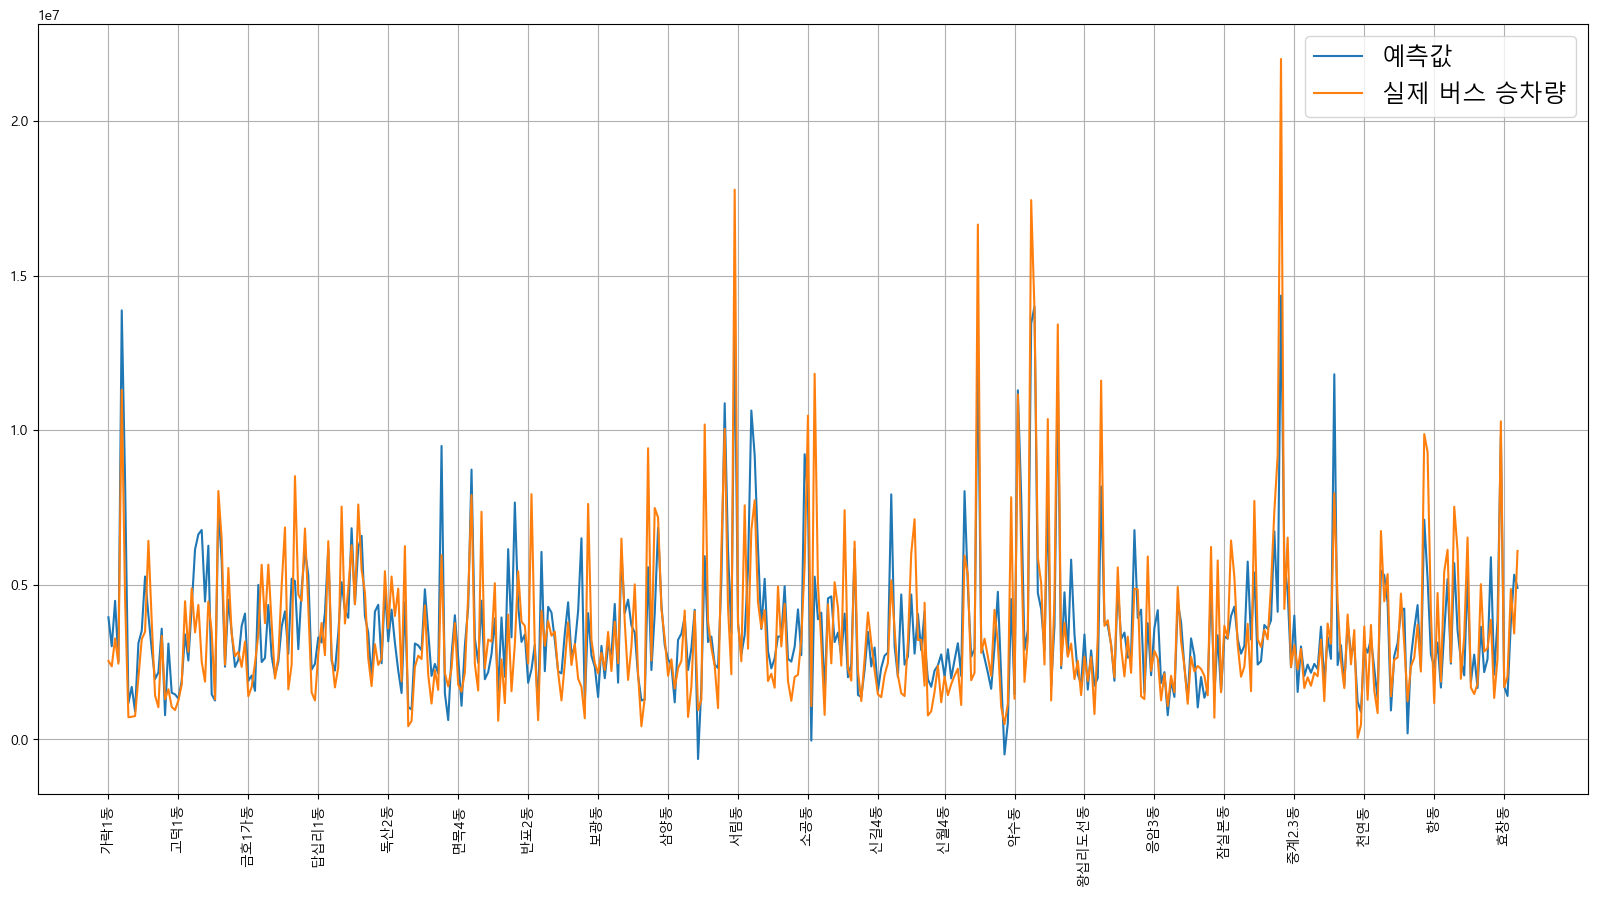

In [112]:
import matplotlib.pyplot as plt

# 플롯의 크기 설정
plt.figure(figsize=(20, 10))

# 예측값 그래프
plt.plot(df40['행정동'], df40['예측값'], label='예측값')


plt.plot(df40['행정동'], df40['버스 승차량'], label='실제 버스 승차량')
plt.legend(fontsize='xx-large')
plt.xticks(rotation = 90)
plt.xticks(df40['행정동'][::len(df40['행정동'])//20])

plt.grid(True)
plt.show()

<AxesSubplot:>

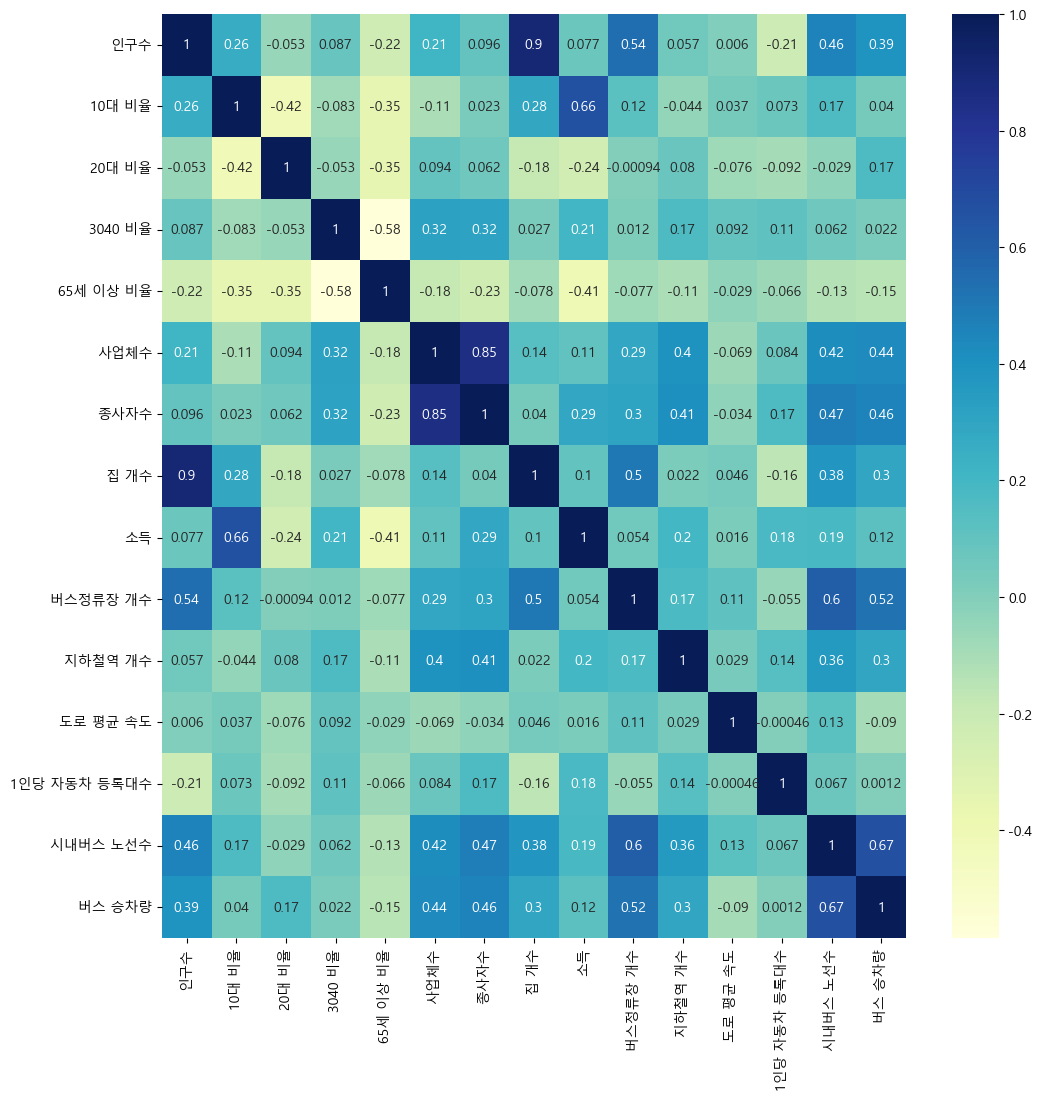

In [ ]:
plt.figure(figsize = (12, 12))
sns.heatmap(data = rem_outlier.corr(), annot=True, cmap='YlGnBu')

In [ ]:
## 2024년 데이터에 피팅

import pandas as pd


bus = pd.read_csv('./data/서울시 행정동별 버스 총 승차 승객수 정보 2024.csv', encoding = 'cp949')
bus['기준_날짜'] = bus['기준_날짜'].astype('str')
## 각종자료 시각화

In [ ]:
bus_2024 = bus[bus['기준_날짜'].str.startswith('2024')]
bus_2024['기준_날짜'] = bus['기준_날짜'].str[:-2]

C:\Users\KJY\AppData\Local\Temp\ipykernel_8776\1496562342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_2024['기준_날짜'] = bus['기준_날짜'].str[:-2]


In [ ]:
bus_2024_on = bus_2024.groupby(['기준_날짜', '행정동_ID']).sum()

bus_2024_on.reset_index(inplace=True)

In [ ]:
bus_2024_on.iloc[:, 0:3]

,기준_날짜,행정동_ID,버스_승객_수
0,202401,1101053,547704.0
1,202401,1101054,82768.0
2,202401,1101055,161478.0
3,202401,1101056,171990.0
4,202401,1101057,37301.0
...,...,...,...
421,202401,11170740,0.0
422,202401,11230511,0.0
423,202401,11250550,215629.0
424,202401,11250760,0.0
